In [1]:
import sys
from pathlib import Path
from copy import deepcopy
# from os.path import exists

# Add the path to the sys.path list
sys.path.append(Path(Path.cwd(), "..", "galfitlib").as_posix())

In [2]:
#from galfitlib.classes.components import *
from galfitlib.classes.containers import *
from galfitlib.functions.helper_functions import *
from galfitlib.pipeline.s2g_feedme_gen import *

In [3]:
from astropy.io import fits
from astropy.utils.data import get_pkg_data_filename
from scipy import fft
import numpy as np
import matplotlib.pyplot as plt

In [4]:
#Imports
import ipywidgets as widgets
from IPython.display import display
from IPython.display import Audio

In [5]:
import sounddevice as sd

In [6]:
def music_to_galaxy_properties(sersic_object : Sersic):
    '''
    Bb – ‘Magnitude’ [3,25] -> Linearly [0,1] | Set: 15 | Direction: Longer -> Lower Value
    F – ‘Eff_Rad’ [0,1] | Set: 0.5 | Direction: Longer -> Higher Value
    C – ‘Sersic_Index’ [0,10] (log scaling) | Set: 1.0 | Direction: Longer -> Higher Value
    G – ‘Axis_Ratio’ [0.5,1] | Set: 1.0 | Direction: Longer -> Lower Value
    D – ‘Pos_Angle’ [0,180] -> [0,1] Sin(theta/2) | Set: 0 | Direction: Longer -> Higher Value
    
    Returns: 
        disk: Float, 
        bulge: Float,
        dict_galfit: Dictionary
    '''
        
    def normalize(val, val_min=1.0, val_max=5.0):
        '''
        Normalizes input duration to [0.5,1]
        '''
        norm = np.abs((val - val_min)/(val_max - val_min))
        return norm

    sersic_object.magnitude.value        = (25.-3.)*(1.0 - normalize(dict_music['Bb']))+3.
    sersic_object.effective_radius.value = (1.0 - 0.0)*normalize(dict_music['F'])+ 10
    sersic_object.sersic_index.value     = (10.0 - 0.0)*normalize(dict_music['C']) + 0.5
    sersic_object.axis_ratio.value       = (1 - 0.5)*normalize(dict_music['G']) + 0.5
    sersic_object.position_angle.value   = 2*np.arcsin(normalize(dict_music['D']))*180.0/np.pi
    
    return bulge, disk # , sersic_object 

In [7]:
g_prefix = "galaxy"
g_number = 0

cwd = Path.cwd()

IN_DIR  = pj(cwd, "music-in")
TMP_DIR = pj(cwd, "music-tmp")
OUT_DIR = pj(cwd, "music-out")

previous = False

In [8]:
# Function to update the array image when slider value changes
def update_image_array(change):
    # Update the image data based on the slider value
    new_image_data_array = image_data_array * change.new

    # Update the array image with new data
    image_array.set_data(new_image_data_array)

    # Redraw the figure
    fig.canvas.draw()

In [9]:
import librosa
x, sr = librosa.load('brown_alma_mater.mp3')

In [10]:
# import pygame
# 
# def play_audio(file_path):
#     # Initialize Pygame mixer
#     pygame.mixer.init()
# 
#     # Load the audio file
#     pygame.mixer.music.load(file_path)
# 
#     # Play the audio file
#     pygame.mixer.music.play()
# 
#     # Keep the script running while the audio is playing
#     while pygame.mixer.music.get_busy():
#         pygame.time.Clock().tick(10)
# 
# 
# audio_file = "brown_alma_mater.mp3"
# play_audio(audio_file)

In [11]:
%matplotlib notebook

In [51]:
print(t_step - t_step_size, t_step)

-99225 11025


The freq is (2363203694.980053+5119.532655647039j) Hz.


<Figure size 640x480 with 0 Axes>

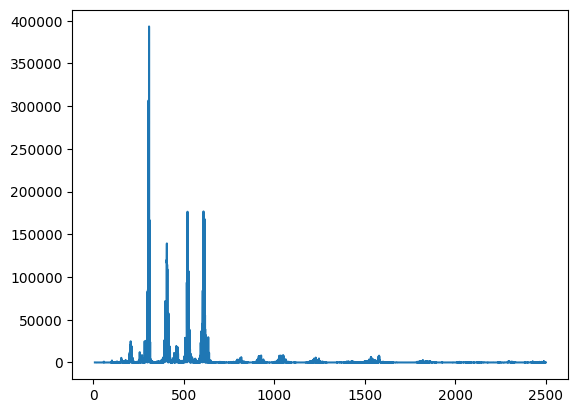

In [55]:
count = 0
g_number = 0
while g_number == 0:
    plt.clf()
    gname = f"{g_prefix}_{g_number}"
    filename = f"{pj(IN_DIR, gname)}.fits"
    #template = pj(_MODULE_DIR, "template.fits")
    #sp(f"cp {template} {filename}")
    #gen_template(filename)
    
    dict_music = {
        'Bb': 3.0,
        'F': 0.5,
        'C': 1.0,
        'G': 0.5,
        'D': 0.0,
        'M': 1,
        'm': 0
    }

    if not exists(pj(OUT_DIR, gname)):
        pj(OUT_DIR, gname).mkdir()

    feedme = pj(OUT_DIR, gname, f"{gname}.in")
    input_filename = pj(IN_DIR, f"{gname}.fits")
    output_filename = pj(OUT_DIR, gname, f"{gname}_out.fits")
    
    x     = 10000
    count = 0
    filename = "brown_alma_mater.mp3"
    
    while x != 0 and count < 1:
        # x = int(input("Waiting..."))
        #sr = 48000
        #duration = 6
        signal, sr = librosa.load(filename)
        t = np.arange(librosa.get_duration(path = filename), step = 1/sr)
        #Nsamples = int(duration*sr)
        # Cmaj = sd.rec(Nsamples, samplerate=sr, channels=1, blocking=True)[:,0]#dur5
        
         #np.arange(Nsamples)/sr
        #extracting chord and duration
        #ignore first 1 seconds
        # blur(abs(signal)) to find peaks
        # FT first peak to get chord
        # output as string
        # time between this and last peak, output this too

        ignore = 0.5 # seconds
        signal = signal[t > 0.5]
        t      = t[t > 0.5]
        
        s = 0.01
        t_step_size = 5 * sr
        t_initial   = int(ignore * sr) + t_step_size
        
        for t_step in range(t_initial, len(t), t_step_size):
            
            #t_step = t[i_step] - t[i_step - i_step_size]
            cutsignal = signal[t_step - t_step_size : t_step]
            
            blurProfile = (1/np.sqrt(2*np.pi*s**2))*np.exp(-0.5*(np.linspace(-3*s, 3*s, int(6*s*sr))/s)**2)
    
            signalBlurred = np.convolve(cutsignal**2, blurProfile, mode='same')
    
            chordrange = signalBlurred>100
    
            FT = fft.fft(cutsignal[chordrange])
            freqs = fft.fftfreq(len(cutsignal[chordrange]), d=1/sr)
    
            FT = FT[freqs>=0]
            freqs = freqs[freqs>=0]
    
            fmask = (freqs>100)&(freqs<2000)
    
            noteBins = 220*(2**((np.arange(12*3)-0.5)/12)) # starting from A below middle
    
            peaks = np.argsort(FT)[-3:]
            
            #sectionMask = (t>0.6)&(t<0.65)
    
            #section = signal[sectionMask]
    
            FT = fft.fft(cutsignal)
            freqs = fft.fftfreq(len(cutsignal), d=1/sr)
    
            mask = (freqs>10)&(freqs<2500)
            
            plt.clf()
            fig,ax = plt.subplots()
            ax.plot(freqs[mask], np.abs(FT[mask])**2)
            plt.show()
            
            break
        
        # bulge = Sersic(
        #         component_number = 1,
        #         position = (74, 74),
        # )
        # 
        # disk  = Sersic(
        #         component_number = 2,
        #         position = (74, 74),
        # )
        # 
        # if dict_music["m"] == 1.0:
        #     music_to_galaxy_properties(bulge)
        #     
        # elif dict_music["M"] == 1.0:
        #     music_to_galaxy_properties(disk)
        # 
        # header = GalfitHeader(
        #         galaxy_name = gname,
        #         input_image = input_filename,
        #         output_image = output_filename,
        #         optimize = 1,
        #         region_to_fit = (0,147,0,147)
        # )
        # 
        # galaxy_feedme = FeedmeContainer(
        #         path_to_feedme = feedme, 
        #         header = header,
        #         bulge  = bulge,
        #         disk   = disk
        # )
        # 
        # galaxy_feedme.to_file()
        # 
        # #print(galaxy_feedme)
        # process = sp(f"{RUN_GALFIT} {feedme}")
        # 
        # # Open the FITS file
        # fits_file = fits.open(output_filename)
        # 
        # # Extract the image data from the FITS file
        # image_data_fits     = fits_file[0].data - galaxy_feedme.sky.sky_background.value
        # new_image_data_fits = deepcopy(image_data_fits)
        # 
        # #image_data_array = fits_file[1].data
        # 
        # # Close the FITS file
        # fits_file.close()
        
        # # Create a figure and subplots
        # fig, ax1 = plt.subplots(1, 1, figsize=(10, 5))
        # 
        # # Display the FITS image
        # image_fits = ax1.imshow(np.log(1 + image_data_fits), cmap='gray')
        # 
        # # Display the array image
        # #image_array = ax2.imshow(image_data_array, cmap='gray')
        # 
        # # Create a slider widget for the FITS image
        # slider_fits = widgets.FloatSlider(value = 1.0, min = 0.0, max = 2.0, step=0.01, description='FITS Scale:', continuous_update=True)
        # 
        # # Create a slider widget for the array image
        # #slider_array = widgets.FloatSlider(value=1.0, min=0.1, max=2.0, step=0.1, description='Array Scale:', continuous_update=True)
        # 
        # # Function to update the FITS image when slider value changes
        # def update_image_fits(change):
        #     # Update the image data based on the slider value
        #     new_image_data_fits = change.new * np.log(1 + image_data_fits)
        # 
        #     # Update the FITS image with new data
        #     image_fits.set_data(new_image_data_fits)
        # 
        #     # Redraw the figure
        #     fig.canvas.draw()
        # 
        # # Attach the update_image_fits function to the FITS slider's value change event
        # slider_fits.observe(update_image_fits, 'value')
        # 
        # # Attach the update_image_array function to the array slider's value change event
        # #slider_array.observe(update_image_array, 'value')
        # 
        # # Display the slider widgets
        # display(widgets.HBox([slider_fits])) #, slider_array]))
        # 
        # # Add any additional customization you need to the subplots
        # ax1.set_title('FITS Image')
        # ax1.set_xlabel('X-axis')
        # ax1.set_ylabel('Y-axis')
        # 
        # #ax2.set_title('Residual')
        # #ax2.set_xlabel('X-axis')
        # #ax2.set_ylabel('Y-axis')
        # 
        # # Show the plot
        # plt.show()
            
        # x = input()
        count += 1
        
    g_number += 1

<Figure size 640x480 with 0 Axes>

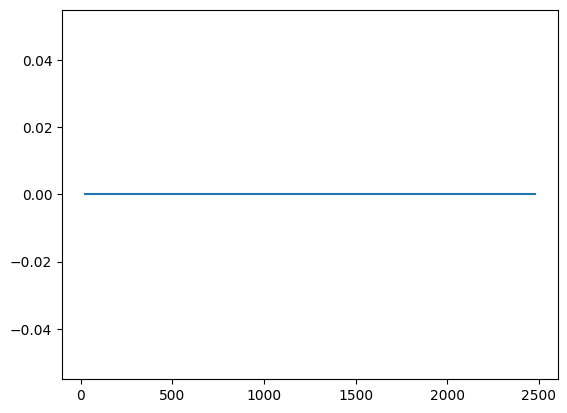

In [30]:
plt.clf()
fig,ax = plt.subplots()
ax.plot(freqs[mask], np.abs(FT[mask])**2)
plt.show()